In [2]:
from collections import OrderedDict

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from dataclasses import dataclass
from datetime import date, datetime


@dataclass
class ModelStatus:
    model: str
    birth: date
    data: str
    loss: list

class IndexDataset(Dataset):
    def __init__(self, out_indices=None):
        _dataset = datasets.MNIST(
            root="/home/secondvoca/sdc_ae_23/data",
            train=True,
            download=True,
            transform=ToTensor(),
        )
        if out_indices:
            self.x = _dataset.data[] # todo
        self.x = _dataset.data / 255.0
        self.y = _dataset.targets

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], idx


class Manager:
    def __init__(self, prepare_default=False) -> None:
        if prepare_default:
            self.prepare_default_model()
            self.prepare_MNIST_train_set()
            self.set_default_optimizer()
            self.set_default_VAE_loss()

            self.model_status = ModelStatus("VAE", datetime.now(), "MNIST", [])

    def set_default_optimizer(self):
        self.optimizer = torch.optim.Adam(self.model.parameters())

    def prepare_default_model(self):
        _encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 4),
        )

        _decoder = nn.Sequential(
            nn.Linear(2, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 784),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28)),
        )

        self.model = nn.Sequential(
            OrderedDict(
                [
                    ("encoder", _encoder),
                    ("decoder", _decoder),
                ]
            )
        )

    def set_MNIST_data_with_index(self):
        _dataset = IndexDataset()
        self.dataloader = DataLoader(_dataset, 128, True)

    def prepare_MNIST_train_set(self):
        _dataset = datasets.MNIST(
            root="/home/secondvoca/sdc_ae_23/data",
            train=True,
            download=True,
            transform=ToTensor(),
        )

        self.dataloader = DataLoader(_dataset, 128, True)

    def default_VAE_loss(self):
        h = self.model.get_submodule("encoder")(self._x)
        mu = h[:, :2]
        log_sigma = h[:, 2:4]
        sigma = log_sigma.exp()
        z = torch.randn_like(mu, device=self.device) * sigma + mu
        pred = self.model.get_submodule("decoder")(z)
        kl = 0.5 * (mu.square() + sigma.square() - log_sigma - 1).sum()
        ll = F.binary_cross_entropy(pred, self._x, reduction="sum")
        loss = (ll + kl) / len(self._x)
        return loss

    def set_default_VAE_loss(self):
        self.criterion = self.default_VAE_loss

    def get_cuda_device_or_cpu(self):
        if torch.cuda.is_available():
            cuda_count = torch.cuda.device_count()

            no = 0
            mem_available = 0

            for i in range(cuda_count):
                tmp_available = torch.cuda.mem_get_info(i)[0]
                if mem_available < tmp_available:
                    no = i
                    mem_available = tmp_available
            return f"cuda:{no}"
        return "cpu"

    def train(self, epochs, record=False, **kwargs):
        self.device = self.get_cuda_device_or_cpu()
        self.model.to(self.device)
        self.model.train()

        print(f"Now, it's working on {self.device}.")

        if record:
            record_step = kwargs.pop("record_step", 1)
            XLIM = kwargs.pop("XLIM", [-3.0, 3.0])
            YLIM = kwargs.pop("YLIM", [-3.0, 3.0])
            record_image_count = kwargs.pop("record_image_count", 11)
            xs = torch.linspace(XLIM[0], XLIM[1], record_image_count)
            ys = torch.linspace(YLIM[1], YLIM[0], record_image_count)
            grid_x, grid_y = torch.meshgrid(xs, ys, indexing="xy")
            record_points = torch.dstack([grid_x, grid_y]).view(-1, 2).to(self.device)
            self.model_status.image_list = []

        for epoch in tqdm(range(epochs)):
            tmp_loss = 0

            for x, _ in self.dataloader:
                self._x = x.to(self.device)
                loss = self.criterion()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                tmp_loss += loss

            self.model_status.loss.append(
                tmp_loss.detach().item() / len(self.dataloader)
            )

            if record and ((epoch + 1) % record_step == 0):
                with torch.no_grad():
                    imgs = (
                        self.model.get_submodule("decoder")(record_points)
                        .detach()
                        .cpu()
                    )
                    grid = torch.zeros(28 * record_image_count, 28 * record_image_count)
                    for i in range(11):
                        for j in range(11):
                            grid.narrow(0, i * 28, 28).narrow(1, j * 28, 28).copy_(
                                imgs[i * record_image_count + j].view(28, 28)
                            )
                    self.model_status.image_list.append(grid)

        self.model.to("cpu")
        self.model.eval()

In [5]:
manager = Manager(prepare_default=True)
manager.set_MNIST_data_with_index()

for x, y, idx in manager.dataloader:
    print(x.shape)
    print(x.max(), x.min())
    print(y.shape)
    print(idx.shape)
    print(idx[:30])
    break

torch.Size([128, 28, 28])
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
torch.Size([128])
torch.Size([128])
tensor([14897, 51144, 20430, 49125, 20406, 11340, 15865, 26929, 13031, 31914,
        12594, 14209, 41625, 47533, 14476, 41341, 30310, 55907, 23579, 59957,
        30731, 22841, 15524, 12963, 52193, 47809, 24905, 24414, 38523, 31195])


ValueError: too many values to unpack (expected 2)

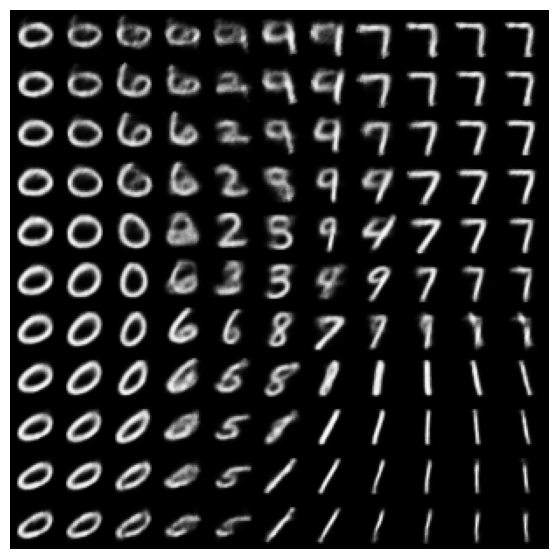

In [42]:
fig = plt.figure(figsize=(7, 7))
plt.axis("off")
ims = [
    [plt.imshow(i, animated=True, cmap=plt.cm.gray, vmax=1, vmin=0)]
    for i in manager.model_status.image_list
]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=500, blit=True)

HTML(ani.to_jshtml())

In [33]:
xs = torch.linspace(-3, 3, 11)
ys = torch.linspace(3, -3, 11)
grid_x, grid_y = torch.meshgrid(xs, ys, indexing="xy")
torch.dstack([grid_x, grid_y]).view(-1, 2)

tensor([[-3.0000e+00,  3.0000e+00],
        [-2.4000e+00,  3.0000e+00],
        [-1.8000e+00,  3.0000e+00],
        [-1.2000e+00,  3.0000e+00],
        [-6.0000e-01,  3.0000e+00],
        [-1.1921e-07,  3.0000e+00],
        [ 6.0000e-01,  3.0000e+00],
        [ 1.2000e+00,  3.0000e+00],
        [ 1.8000e+00,  3.0000e+00],
        [ 2.4000e+00,  3.0000e+00],
        [ 3.0000e+00,  3.0000e+00],
        [-3.0000e+00,  2.4000e+00],
        [-2.4000e+00,  2.4000e+00],
        [-1.8000e+00,  2.4000e+00],
        [-1.2000e+00,  2.4000e+00],
        [-6.0000e-01,  2.4000e+00],
        [-1.1921e-07,  2.4000e+00],
        [ 6.0000e-01,  2.4000e+00],
        [ 1.2000e+00,  2.4000e+00],
        [ 1.8000e+00,  2.4000e+00],
        [ 2.4000e+00,  2.4000e+00],
        [ 3.0000e+00,  2.4000e+00],
        [-3.0000e+00,  1.8000e+00],
        [-2.4000e+00,  1.8000e+00],
        [-1.8000e+00,  1.8000e+00],
        [-1.2000e+00,  1.8000e+00],
        [-6.0000e-01,  1.8000e+00],
        [-1.1921e-07,  1.800

torch.Size([308, 308])


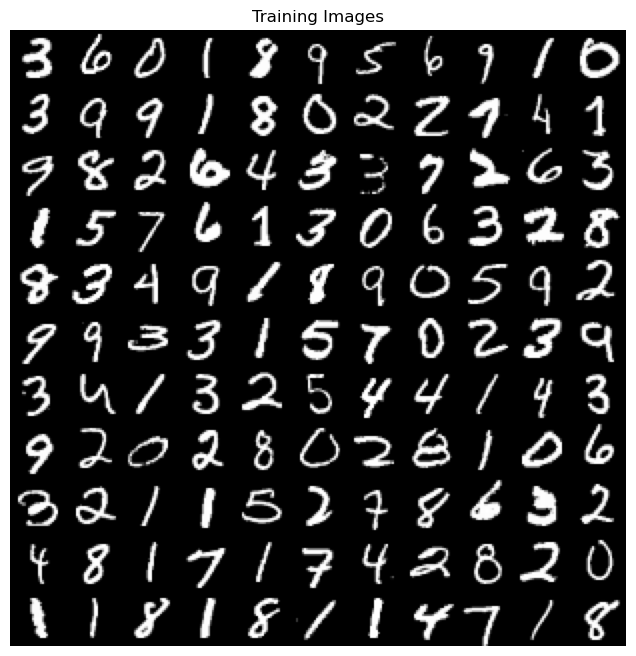

In [26]:
for x, _ in manager.dataloader:
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training Images")

    grid = torch.zeros(28 * 11, 28 * 11)
    print(grid.shape)

    imgs = x[:121]
    idx = 0
    for i in range(11):
        for j in range(11):
            grid.narrow(0, i * 28, 28).narrow(1, j * 28, 28).copy_(
                imgs[i * 11 + j].view(28, 28)
            )

    # plt.imshow(grid.permute(1, 2, 0), cmap='gray', vmax=1, vmin=0)
    plt.imshow(grid, cmap=plt.cm.gray, vmax=1, vmin=0)
    plt.show()

    break

In [12]:
28 * 11

308

In [16]:
torch.randn(10)

tensor([ 3.1917, -0.2398, -0.1227, -1.2220, -0.4667, -0.4693, -0.0139,  0.9559,
         0.7768,  0.7699])